A fine-tuned language model for pictionary word list completion (topic/category phrase + example words -> list of 30 examples). For example, one may complete the list

"A list of round fruits: peach, apricot, lime, plum,"

with

"mango, cherry, pineapple, strawberry, pumpkin, watermelon, orange, pomegranate, melon, apple, pear, grapefruit, papaya, lemon, kiwi, passionfruit, blueberry, raspberry, blackberry, cantaloupe, nectarine, pitaya, persimmon, durian, guava, jackfruit, avocado, lychee, soursop, guarana, mangosteen, blackcurrant, cranberry"

using this model. These words should be compatible with pictionary/skribbl.io; i.e., "sketchable" within a few minutes, and easily recognisable. Scroll to the end for more examples, or see the file `data/examples.txt`. Sketchability parameter estimation examples can also be found in `data/data.tsv`.

In [1]:
import csv
import time
import string
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import GPT2ForSequenceClassification, GPT2LMHeadModel, ReformerModelWithLMHead, \
                         get_linear_schedule_with_warmup
from pytorch_transformers import GPT2Tokenizer
from Learning import *


Complete.


[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
   ###   Options   ###

model_name = "ernst_one"
gpt2_modelkey = "gpt2-xl"         # Pretrained model to start from
test_set_frac = 0.25                 # Fraction of samples to keep as separate test set (word lists)
sample_test_n = 200                  # Number of randomly generated prompts for each sample when validating model
log_period_batches = 10              # Batches per iteration
learning_rate = 2e-5                 # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
adam_epsilon = 1e-8                  # Adam epsilon (default is 1e-8)
n_sched_warmup = 0                   # Linear scheduler for optimizer number of warmup steps
batch_size = bsz = 64                # Samples per batch
N_train_batches = int(1e7 / bsz)     # Total number of batches to show model
min_nw, max_nw = 0.7, 0.9            # Minimum and maximum fraction of list to keep when truncating
max_listlen = 15                     # Maximum number of words in the list when creating a prompt (at least prior to * max_nw)
lidstone_e = 0.01                    # Smoothing for possible words/subwords which are not in the missing list words set
max_len = 96                         # Max n. tokens specified in order to match a power of 2, applied prior to *max_nw (tokens)

In [3]:
dev = "cuda" if pt.cuda.is_available() else "cpu"
d = device = pt.device(dev)
# world_size = 1
# rank = 0
# def setup(rank, world_size): 
#     os.environ['MASTER_ADDR'] = '127.0.0.1'
#     os.environ['MASTER_PORT'] = find_free_port()
#     dist.init_process_group("gloo", rank=rank, world_size=world_size)  # initialize the process group
# def cleanup():
#     dist.destroy_process_group()
# # mp.spawn(setup, args=(rank, world_size), nprocs=world_size)
# setup(rank, world_size)

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained(gpt2_modelkey.replace("-xl", "-large"), padding=True)

In [5]:
cats, cats_sing, phrases = Listset().load()  # Import word lists dataset

In [6]:
tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    tokenizer.encode("A list of round fruits: apples,"), \
    tokenizer.encode("oranges, pears,")

([317, 1351, 286, 2835, 15921, 25, 22514, 11, 48389, 11, 279, 4127, 11],
 [317, 1351, 286, 2835, 15921, 25, 22514, 11],
 [48389, 11, 279, 4127, 11])

In [7]:
lprompts_encoded = [[tokenizer.encode(prompt), "types of" in prompt] for prompt in lprompts]
cats_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats]
cats_sing_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats_sing]
phrases_e = [[tokenizer.encode(p + ', ') for p in ps] for ps in phrases]
N_tokens = len(tokenizer)
N_wordlists = len(cats)

In [8]:
lprompts_encoded = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded]
cats_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e]
cats_sing_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e]
phrases_e = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e]
# N_tokens = pt.tensor(N_tokens, device=d)
# max_len = pt.tensor(max_len, device=d)
# bsz = pt.tensor(batch_size, device=d)
# lprompts_encoded = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded]
# cats_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e]
# cats_sing_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e]
# phrases_e = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e]
# N_tokens = pt.tensor(N_tokens, device=d)
# max_len = pt.tensor(max_len, device=d)
# bsz = pt.tensor(batch_size, device=d)
lidstone_e = pt.tensor(lidstone_e, device=d)
y_zero = (lidstone_e / N_tokens).repeat(N_tokens)

In [9]:
# Generate a fixed test set and save to disk, using nw_draw = 15. This function defines the next list token prediction problem
def gen_truncated_list(prmt, p):  # prmt = prompt tokens, p = list word/phrase tokens
    tkzs, sent, tkix = [], [], 0
    max_ws = max_len - len(prmt)
#     incl_words = pt.randperm(len(p))[:min(max_listlen, len(p))]
    incl_words = np.random.choice(len(p), min(max_listlen, len(p)), replace=False)
    for phz_i in incl_words:
        phz_enc = p[phz_i]
        tkzs.append((tkix, phz_enc))
        tkix += len(phz_enc)
        sent.append(phz_enc)
        if tkix >= max_ws:
            tkix = max_ws
            break
    sent = pt.hstack(sent)[:max_ws]
    missing_w = [p[i] for i in range(len(p)) if i not in incl_words]
    trunc_ix = np.random.randint(round(tkix * min_nw), round(tkix * max_nw))
    trunc_n = min([(trunc_ix - ix) for (ix, enc) in tkzs if ix <= trunc_ix])  # N. end phrase tokens
    missing_w += [enc for (ix, enc) in tkzs if ix >= (trunc_ix - trunc_n)]
    missing_matches = missing_w
    if trunc_n > 0:
        phr_start = trunc_ix - trunc_n
        partial_phr = sent[phr_start:trunc_ix]
        missing_matches = [enc for enc in missing_w if len(enc) >= trunc_n and all(enc[:trunc_n] == partial_phr)]
    next_tokens = [enc[trunc_n] for enc in missing_matches]
    norm = len(next_tokens) * (1.0 + lidstone_e)
    tunit, y_ = pt.tensor(1 / norm, device=d), y_zero.clone()
    for token in next_tokens: y_[token] += tunit
    return pt.hstack([prmt, sent[:trunc_ix]]), y_
def gen_samples_uniform(xcp, xcs, xp, nw, verbose=False):  # Weight testing samples (word lists) uniformly
    xs, ys, sqlens, j = [], [], [], 0
    for i in range(len(xcp)):
        x, y, sqlen = [], [], []
        cp, cs, p = xcp[i], xcs[i], xp[i]
        for m in range(nw):
            prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
            cat_ix = np.random.randint(len(cp))
            x_, y_ = gen_truncated_list(pt.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
            x.append(x_)
            y.append(y_)
            sqlen.append(len(x_))
            j += 1
            if verbose and j % 100 == 0:
                sys_print("\rDone: " + str(j))
        xs.append(x)
        ys.append(y)
        sqlens.append(sqlen)
    if verbose: sys_print("\rDone: " + str(j) + ", finished!\n")
    return xs, ys, sqlens
def gen_samples(xcp, xcs, xp, n):  # Maximise training batch diversity by randomly sampling the word lists
    xs, ys, sqlens, j = [], [], [], 0
    n_sets = len(xcp)
    for m in range(n):
        i = np.random.randint(n_sets)
        cp, cs, p = xcp[i], xcs[i], xp[i]
        prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
        cat_ix = np.random.randint(len(cp))
        x_, y_ = gen_truncated_list(pt.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
        xs.append(x_)
        ys.append(y_)
        sqlens.append(len(x_))
    return xs, ys, sqlens

In [10]:
N_test = int(test_set_frac * N_wordlists)
N_train = N_wordlists - N_test
test_idx = np.random.choice(N_wordlists, N_test, replace=False)
save_ld(test_idx, "test.data")
# test_idx = load_ld("test.data")
# test_idx = np.array([0, 2])  # Round fruits and chemical elements
train_idx = [i for i in range(N_wordlists) if i not in test_idx]
print("Train:")
print([cats[i][0] for i in train_idx])
print("Test:")
print([cats[i][0] for i in test_idx])
cats_e_test, cats_sing_e_test = [cats_e[i] for i in test_idx], [cats_sing_e[i] for i in test_idx]
phrases_e_test = [phrases_e[i] for i in test_idx]
cats_e_train, cats_sing_e_train = [cats_e[i] for i in train_idx], [cats_sing_e[i] for i in train_idx]
phrases_e_train = [phrases_e[i] for i in train_idx]
test_cats = [cats[i][0] for i in test_idx]
test_xs, test_ys, test_sqlens = gen_samples_uniform(cats_e_test, cats_sing_e_test, phrases_e_test, sample_test_n, verbose=True)

Train:
['round fruits', 'wild animals', 'chemical elements', 'microorganisms', 'music', 'outback experiences', 'scientific cycles', 'buildings']
Test:
['machine learning algorithms', 'dramatic and literature elements']


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Done: 400, finished!


In [11]:
# Define next batch function
def adapt_form(xs, ys, sqlens):
    xs = pt.vstack([F.pad(x, (0, max(0, max_len - len(x))), mode='constant', value=pad_token)[:max_len] for x in xs])
    return xs, pt.vstack(ys), pt.tensor(sqlens, device=d)
def next_batch(sz):
    global cats_e_train, cats_sing_e_train, phrases_e_train
    return adapt_form(*gen_samples(cats_e_train, cats_sing_e_train, phrases_e_train, sz))

In [12]:
if 'model' in locals():
    del model
pt.cuda.empty_cache()
print(gc.collect())
create_folder("models")
create_folder("models/pretrained")
create_folder("models/pretrained/GPT2LMHead")
# model_ = GPT2ForSequenceClassification.from_pretrained('gpt2-large',
# model_ = GPT2LMHeadModel.from_pretrained('gpt2-xl',
# model_ = GPT2LMHeadModel.from_pretrained('gpt2-large',
# model_ = GPT2LMHeadModel.from_pretrained('gpt2-medium',
model_ = GPT2LMHeadModel.from_pretrained(gpt2_modelkey,
    output_hidden_states=False, output_attentions=False, 
    cache_dir="models/pretrained/GPT2LMHead")
# model_.parallelize()
device_map = {0: [0, 1, 2],
              1: [3, 4, 5, 6, 7, 8],
              2: [9, 10, 11, 12, 13, 14],
              3: [15, 16, 17, 18, 19, 20],
              4: [21, 22, 23, 24, 25, 26, 27],
              5: [28, 29, 30, 31, 32, 33, 34],
              6: [35, 36, 37, 38, 39, 40, 41],
              7: [42, 43, 44, 45, 46, 47],
             }
model_.parallelize(device_map)
# model_ = model_.to(d)
print("GPT2 device:", model_.device)
model_.resize_token_embeddings(N_tokens)
pad_token = model_.config.pad_token_id = model_.config.eos_token_id
pad_token = pt.tensor(pad_token, device=d)
n_embd = pt.tensor(model_.config.n_embd, device=d)
# model = nn.parallel.DistributedDataParallel(model_, device_ids=[d])
# model = nn.DataParallel(
#     model_, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else model_
model = model_
print("Pretrained parameters loaded")
gc.collect()

40
GPT2 device: cuda:0
Pretrained parameters loaded


1271

In [13]:
llayer = None #nn.Linear(n_embd, N_tokens, bias=False).to(d)#.cpu()
# nn.init.xavier_uniform_(llayer.weight)
# llayer = nn.DataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else llayer
# llayer = nn.parallel.DistributedDataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))).to(d)
# softmax = nn.Softmax()
bcewl_loss = nn.BCEWithLogitsLoss()#.to(d)#.cpu()
# bcewl_loss = nn.DataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d) if dev != "cpu" else bcewl_loss
# bcewl_loss = nn.parallel.DistributedDataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d)
# nll_loss = nn.NLLLoss()
# kl_loss = nn.KLDivLoss()
optimizer = pt.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_sched_warmup, num_training_steps=N_train_batches)
def sequence_mask(lengths, maxlen=None, dtype=pt.int):
    if maxlen is None:
        maxlen = lengths.max()
    row_vector = pt.arange(0, maxlen, 1, device=d)
    matrix = pt.unsqueeze(lengths, dim=-1)
    mask = row_vector < matrix

    mask = mask.type(dtype)
    return mask
def train_step():
    global model, llayer, bcewl_loss, optimizer, bsz, scheduler
    x_batch, y_batch, sqlens_batch = next_batch(bsz)

#     for x in x_batch.cpu().detach().numpy():
#         print(tokenizer.decode(x))
    model.zero_grad()
    mask = sequence_mask(sqlens_batch, max_len)
    outputs = model(x_batch.long(), attention_mask=mask)  # Get logits
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens_batch - 1, 1).repeat((1, N_tokens)), 1).type(pt.int64)
    outs = pt.gather(outputs[0], 1, out_idx).squeeze(1)
#     outs = outputs[0][:, -1]
#     logits = llayer(outs)
    logits = outs
    
#     logsofts = pt.log(softmax(logits))
    loss = bcewl_loss(logits, y_batch.float())
    loss = loss.mean()
    correct = pt.mean((y_batch[pt.arange(batch_size), pt.argmax(logits, axis=1)] > (lidstone_e / N_tokens)).float())
    loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    return loss_, correct_

def inference(x, sqlens):
    global model, llayer

    x, sqlens = x, sqlens
#     for x_ in x.cpu().detach().numpy():
#         print(tokenizer.decode(x_))
    mask = sequence_mask(sqlens, max_len)
    outputs = model(x.long(), attention_mask=mask)  # Get logits
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens - 1, 1).repeat((1, N_tokens)), 1).type(pt.int64)
    outs = pt.gather(outputs[0], 1, out_idx).squeeze(1)
#     outs = outputs[0][:, -1]
#     logits = llayer(outs)
    logits = outs
    return logits
def eval_test(x, y, sqlens):
    global bcewl_loss

    with pt.no_grad():
        logits = inference(x, sqlens)
        loss = bcewl_loss(logits, y.float())#.to(d)#.cpu()
        loss = loss.mean()
        correct = pt.mean((y[pt.arange(x.shape[0]), pt.argmax(logits, axis=1)] > (lidstone_e / N_tokens)).float())
        loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    return loss_, correct_

In [14]:
batch_i = 0
best_acc, best_loss = 0, np.inf
best_acc_idx = -1
out_str = ''
create_folder("models")
create_folder("model_logs")
create_folder("models/" + model_name)
graphs_folder = "graphs"
create_folder(graphs_folder)
train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

In [15]:
def iterate_training(verbose=True):
    global model, batch_i, best_acc, best_loss, best_acc_idx, train_loss, train_accuracy, test_loss, test_accuracy
    
    model.train()
    iter_loss, iter_accuracy, b_no_inp = [], [], 0
    while batch_i < N_train_batches:
        batch_i += 1
        if batch_i > 1:
            gc.collect()
            if dev != "cpu": pt.cuda.empty_cache()
            b_loss, b_accuracy = train_step()
            if verbose:
                sys_print('\rLoss, accuracy: ' + str(np.mean(b_loss)) + ', ' + str(np.mean(b_accuracy)) + \
                          ' @ batch '+ str(batch_i - 1) + ' (' + str((batch_i - 1) * batch_size) + ' samples) complete.                  ')
            iter_loss.append(b_loss)
            iter_accuracy.append(b_accuracy)

        if (batch_i - 1) % log_period_batches == 0:  # Test on test set
            model.eval()
            loss, accuracy = [], []
            out_str = '\n'
            for i in range(N_test):
                test_X, test_Y, test_Sqlens = adapt_form(test_xs[i], test_ys[i], test_sqlens[i])
                feed_batches = [range(len(test_X))[i * bsz:(i + 1) * bsz] for i in range((len(test_X) // bsz) + \
                                                                                        (1 if (len(test_X) % bsz) != 0 else 0))]
                if dev != "cpu": pt.cuda.empty_cache()
                ls, cs = zip(*[eval_test(test_X[inds], test_Y[inds], test_Sqlens[inds]) for inds in feed_batches])
                loss.append(np.mean(ls))
                accuracy.append(np.mean(cs))
                out_str += test_cats[i] + ': ' + str(loss[-1]) + ', ' + str(accuracy[-1]) + '\n'
            
            test_l, test_a = np.mean(loss), np.mean(accuracy)
            test_loss.append(test_l)
            test_accuracy.append(test_a)
            if batch_i == 1:
                iter_loss, iter_accuracy = [test_l], [test_a]
            train_l, train_a = np.mean(iter_loss), np.mean(iter_accuracy)
            train_loss.append(train_l)
            train_accuracy.append(train_a)
            iter_loss, iter_accuracy = [], []
            
            val_a = 0
            if test_a > best_acc:      # Save best accuracy model
                best_acc = test_a
                best_loss = test_l
                best_acc_idx = (batch_i - 1) // log_period_batches
                pt.save({"model": model.state_dict(),
#                          "llayer": llayer.state_dict(),
#                          "softrmax": softrmax.state_dict(),
                         "bcewl_loss": bcewl_loss.state_dict(),
#                          "nll_loss": nll_loss.state_dict(),
#                          "kl_loss": kl_loss.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "scheduler": scheduler.state_dict(),
                         }, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches
                
            if verbose:
                clear_output()
                print(out_str + "Batch", batch_i, ':', train_a, test_a, "loss:", train_l, test_l, \
                      "Best:", best_acc, best_loss, 'idx:', best_acc_idx)
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')
#                 g.axhline(y=0.714, ls='--', color='grey')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                g.plot(test_loss, label='test loss')
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        "model_logs/" + model_name + '_log_latest', pad=False)
                plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
                plt.show()
            model.train()
    return best_acc, best_loss


machine learning algorithms: 0.00011573873, 0.578125
dramatic and literature elements: 0.0001001832, 0.80859375
Batch 1021 : 0.8890625 0.6933594 loss: 6.332579e-05 0.000107960965 Best: 0.71484375 0.00011023056 idx: 95


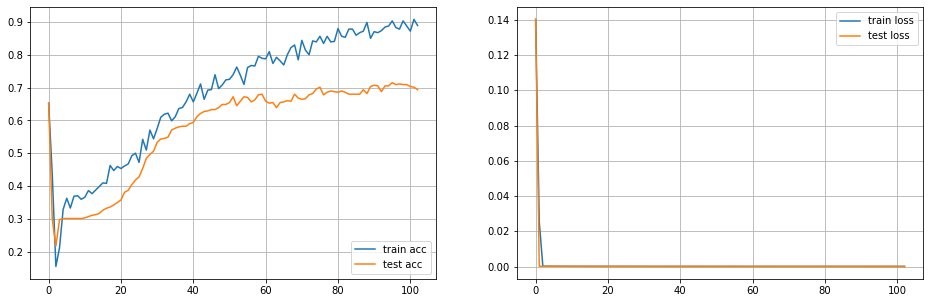

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss, accuracy: 7.741736e-05, 0.9375 @ batch 1028 (65792 samples) complete.                    

KeyboardInterrupt: 

In [16]:
print(gc.collect())
iterate_training()

In [17]:
# Load best model (checkpoint)
pt.cuda.empty_cache()
gc.collect()
cpoint = pt.load("./models/" + model_name + '/' + model_name)
# cpoint = pt.load("./models/" + 'ernst_one - 2k ts' + "/" + model_name)
# cpoint = pt.load("./models/" + 'ernst_one - 3k ts' + "/" + model_name)  # ~3000 training samples observed has current optimum
# cpoint = pt.load("./models/" + 'ernst_one - 30k ts' + "/" + model_name)
model.load_state_dict(cpoint['model'])
bcewl_loss.load_state_dict(cpoint['bcewl_loss'])
optimizer.load_state_dict(cpoint['optimizer'])
scheduler.load_state_dict(cpoint['scheduler'])
# llayer.load_state_dict(cpoint['llayer'])

In [18]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < pt.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = pt.sort(logits, descending=True)
        cumulative_probs = pt.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [19]:
padder = int(pad_token.detach().cpu().numpy())
def append_next_token(sent, top_k=-1, top_p=0.9, temperature=1.0, olen=None):
    print("k =", top_k, ", p =", top_p, ", temp =", temperature)
    global model
    if dev != "cpu": pt.cuda.empty_cache()
    model.eval()
    tokens = tokenizer.encode(sent)
    ou = tokens.copy()
    while len(tokens) < max_len:
        tokens += [padder]
    x = pt.tensor([tokens], device=d)
    logits = inference(x, pt.tensor([len(ou)], device=d))[0]
    logits /= temperature
    logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
    probs = F.softmax(logits, dim=0)
    token = pt.multinomial(probs, 1).detach().cpu().numpy()[0]
    ou += [token]
    prev_len = len(sent) if olen is None else olen
    sent_new = tokenizer.decode(ou)
    print(sent[:prev_len] + '➡' + sent_new[prev_len:])
    return sent_new

# Interactive generation

In [98]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
"")
input_sentence = input_sentence.split(', ')
np.random.shuffle(input_sentence)
input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
olen = len(input_sentence)

In [102]:
input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)



k = 5 , p = 0.9 , temp = 5.0
 A list of types of element of drama and writing: fate, diversion, pace, plot twist, silence, monologue, cliffhanger, surprise, attention, fourth wall,➡,,,


In [193]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
"milk, soda")
input_sentence = input_sentence.split(', ')
np.random.shuffle(input_sentence)
input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
olen = len(input_sentence)

In [204]:
# input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)

# 
input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)


k = 25 , p = 0.7 , temp = 2.0
 A list of types of drink: lemonade, water, tea, milk, coffee, coke, milkshake,➡ water, watery of of, soda, milk


In [107]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider, yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider" + \
# ", yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5pm: Using log_period=1 (max_len=96) reliably finds improvement, need more data and larger gpt2 (medium+)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " milk, vodka, beer, ice water, soda, lassi, juice, alcohol, whiskey")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=2.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " wine, soda, alcohol, beer, liquor, apple cider, whiskey, milk, bourbon, vodka, cider, lemon juice")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:6])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=3.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " beer, milk, juice, wine, spirits, alcohol, soda, whiskey, brandy, apple juice, liquor, ice tea, watermelon juice, vodka," + \
# " lemon tea, apple cider, ale, lager, fruit tea, lime cider, cocktail, mocha, red wine, apple soda")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5am: lr=1e-5, max_len=80, log_period_batches=5 increased accuracy by 8%. Need to add a bunch more data

In [ ]:
# With about half an hour of fine-tuning using 5 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "soda, milk, juice, wine, vodka, gin, lime juice, beer, hot chocolate, cider, whiskey, fruit juice, cocktail, liquor, " + \
# "spirits, watermelon juice, martini, rum, chocolate milk, orangeade")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Without fine tuning (regular GPT-2):
# Initial input words on first line, those eventually found by repeatedly querying model on 2nd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "milk, juice, fruit juice, soda, wine, beer, hot chocolate, chocolate milk, alcohol, cider, ice tea, liquor, spirit")
# input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89, olen=olen) # k = 25 also used

In [ ]:
# Training for too long (in this case ~6:30 hours) overfits
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "beer, juice, soda, liquor, wine, tequila, spirits, alcohol, cocktail, martini, whiskey, rum, vodka")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Changelog 15/04/2021 11am: Found learning rate 1e-7, max_listlen 15, min_nw 0.7, max_nw 0.9, lidstone_e 0.01 ACTUALLY WORKS

In [ ]:
# No fine tuning (testing gpt2) (old append function):
# input_sentence = "A list of types of drink: coffee, water, tea, coke, lemonade, milkshake"
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89)
# A list of types of drink: juice, tea, cider, lemonade, milk, beer, hot chocolate,➡ ice cold milk. Image

Working (reproducible) examples using various non-fine-tuned models:

In [ ]:
# GPT3 (via AI Dungeon) (Randomness = 2.0, model = Dragon):
# sentence = "A list of ML algorithms: inverse reinforcement learning, ELMo, decision tree, LDA, "
# expected_completion = "MLP, MLL, MMM. You can't believe you're actually using these things!"

# sentence = "A list of animals seen in the wild: wolffish, woodlouse, sheep, zebra, yak, "
# expected_completion = "goat, fox, dog, rat. You're guessing that a lot of other animals have been seen as well; maybe even all the animals on your list except for wolf and rat?"

In [ ]:
# GPT2 (via Write with Transformer) (Top-p = 0.67, temperature = 1.89, max time = 1.9):
# sentence = "A list of round fruits: peach, apricot, lime, plum, blackberry, cantaloupe, nectarine, pitaya, persimmon, "
# expected_completion = "mango, papaya and raspberry, as also many"

# sentence = "A list of chemical elements: hydrogen, carbon, oxygen, nitrogen, gold, "
# expected_completion = "silver, aluminum, potassium and phosphorus; atomic number."

# sentence = "A list of microbes found on earth: bacteria, virus, prokaryote, amoeba, "
# expected_completion = "archaea, algae, nematode, euk"